In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import librosa
from pydub import AudioSegment, effects

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

'''
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense, Dropout, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import callbacks

import optuna
from optuna.pruners import MedianPruner, PatientPruner
'''
from tensorflow.keras.utils import to_categorical


In [2]:
# Data from:
# Crowd-sourced Emotional Multimodal Actors Dataset (CREMA-D)
# Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)
# Surrey Audio-Visual Expressed Emotion (SAVEE)
# Toronto Emotional Speech Set (TESS)

df = pd.read_csv('df.csv')
df.head()

,path,sex,emotion
0,./ravdess/Actor_16/03-01-05-01-02-01-16.wav,female,angry
1,./ravdess/Actor_16/03-01-06-01-02-02-16.wav,female,fear
2,./ravdess/Actor_16/03-01-06-02-01-02-16.wav,female,fear
3,./ravdess/Actor_16/03-01-05-02-01-01-16.wav,female,angry
4,./ravdess/Actor_16/03-01-07-01-01-01-16.wav,female,disgust


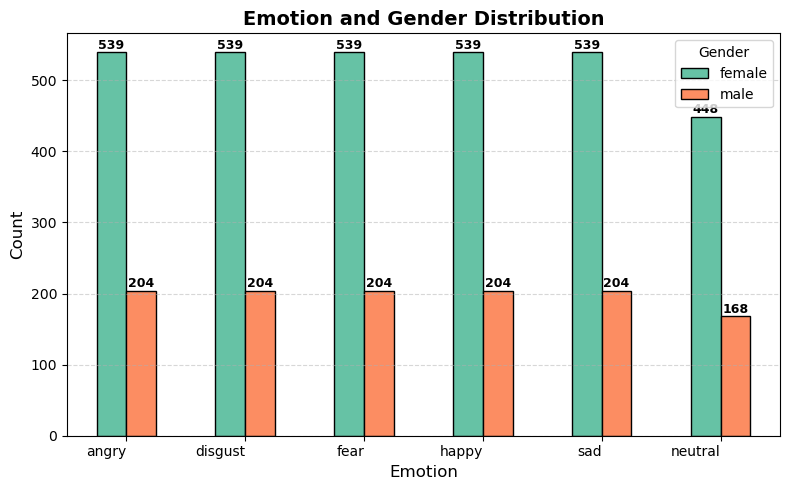

In [7]:
def plot_distribution(df, title='Emotion and Gender Distribution', figsize=(8,5), palette='Set2'):
    # Preparing count data
    count_df = df.groupby(['emotion', 'sex']).size().unstack(fill_value=0)
    
    # Sorting emotions alphabetically
    count_df = count_df.loc[count_df.sum(axis=1).sort_values(ascending=False).index]
    
    # Plot
    ax = count_df.plot(kind='bar', figsize=figsize, color=sns.color_palette(palette, n_colors=len(count_df.columns)), edgecolor='black')
    # Annotating counts on bars
    for p in ax.patches:
        height = int(p.get_height())
        if height > 0:
            ax.annotate(str(height), (p.get_x() + p.get_width() / 2., height + 1), 
                        ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Labelling and styling
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Emotion', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=0, ha='right')
    plt.legend(title='Gender')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()
    
plot_distribution(df)

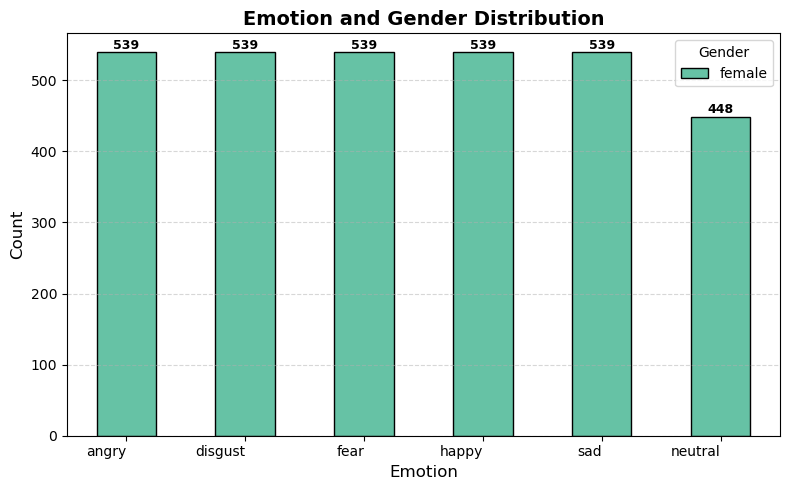

In [4]:
# Gender Specific Model
df = df[df['sex'] == 'female']
plot_distribution(df)

In [8]:
def plotWaveform(y, sr, title):
    plt.figure(figsize=(10,2), dpi=300)
    plt.title(title)
    librosa.display.waveshow(y, sr=sr, lw=0.1)
    plt.show()

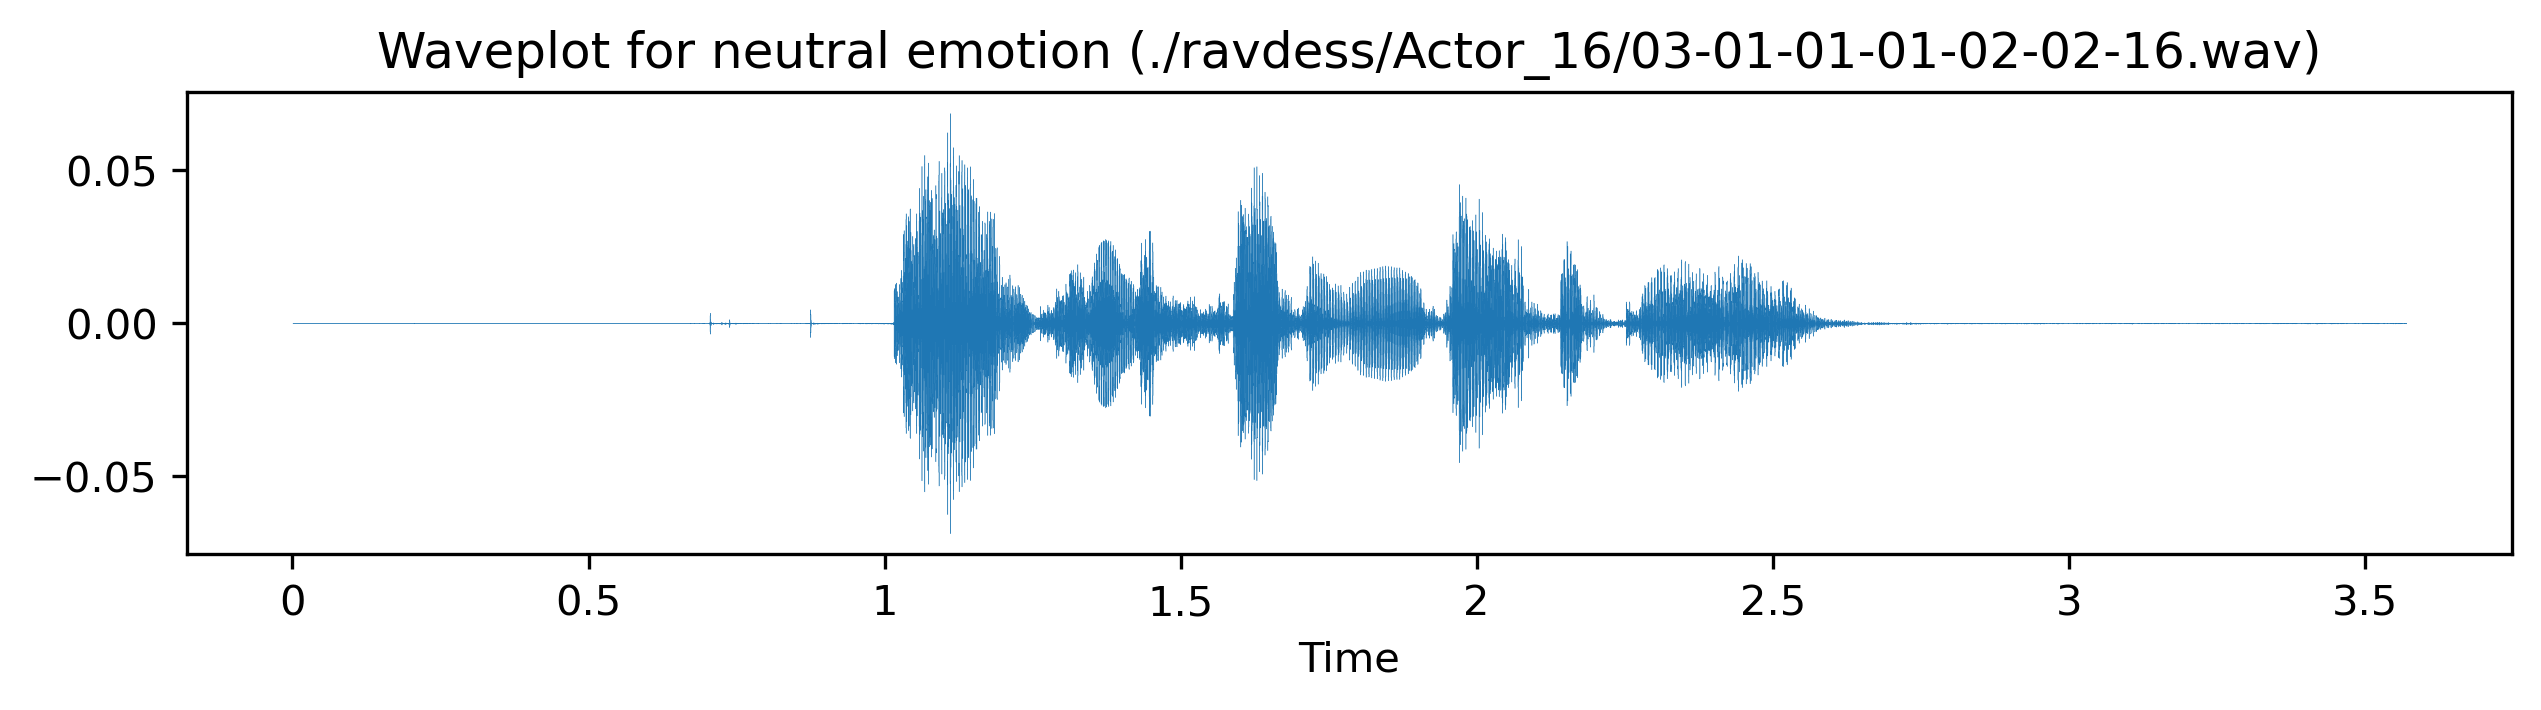

In [9]:
emotionLabel = 'neutral'

path = np.array(df.path[df.emotion == emotionLabel])[0]
title = f"Waveplot for {emotionLabel} emotion" + " (" + path + ")"
y, sr = librosa.load(path)

plotWaveform(y, sr, title)
Audio(path)

In [3]:
# Encoding labels

def encode(label):
    mapping = {
        'neutral': 0,
        'happy': 1,
        'sad': 2,
        'angry': 3,
        'fear': 4,
        'disgust': 5
    }
    return mapping[label]

In [4]:
# Initialize empty lists
zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []


print("Loading saved features into memory...")

for row in tqdm(df.itertuples(index=False), total=len(df)):
    try:
        # Build relative .npy path
        relative_path = os.path.splitext(row.path.lstrip('./'))[0] + '.npy'

        # Full paths to feature files
        zcr_path = os.path.join("zcr", relative_path)
        rms_path = os.path.join("rms", relative_path)
        mfcc_path = os.path.join("mfccs", relative_path)

        # Load features
        zcr = np.load(zcr_path)    # (1, T)
        rms = np.load(rms_path)    # (1, T)
        mfccs = np.load(mfcc_path) # (13, T)

        # Append to respective lists
        zcr_list.append(zcr)
        rms_list.append(rms)
        mfccs_list.append(mfccs)

        emotion_list.append(encode(row.emotion))

    except Exception as e:
        print(f"Failed to load features for {row.path}: {e}")

Loading saved features into memory...


  0%|          | 0/4331 [00:00<?, ?it/s]

100%|██████████| 4331/4331 [00:01<00:00, 2487.35it/s]


In [5]:
# Combine individual features (ZCR, RMS, MFCCs) into a single feature array (X).
# Each audio sample currently has ZCR (1, time_steps), RMS (1, time_steps), and MFCCs (13, time_steps).
# To train the model efficiently, we concatenate all features along the feature dimension so that each sample becomes a 
# single 2D array of shape (time_steps, 15 features).
# This results in a unified dataset X of shape (samples, time_steps, 15), which is ideal for input to models like CNNs, LSTMs, etc. 
# I also prepared the label array y (shape: samples, 1) for supervised learning.

X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2),  # (samples, time_steps, 1)
    np.swapaxes(rms_list, 1, 2),  # (samples, time_steps, 1)
    np.swapaxes(mfccs_list, 1, 2) # (samples, time_steps, 13)
), axis=2).astype('float32')      # Final shape: (samples, time_steps, 15)

# Labels
y = np.expand_dims(np.array(emotion_list), axis=1).astype('int8')  # (samples, 1)

In [6]:
# Train/Validation/Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.12, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42, stratify=y_temp)

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes=6)
y_val_cat = to_categorical(y_val, num_classes=6)
y_test_cat = to_categorical(y_test, num_classes=6)

# **BASELINE MODEL**

In [7]:
# Define Conv1D Model

model = Sequential()
model.add(Conv1D(128, kernel_size=3, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))  # 6 emotion classes


model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

# Callbacks
earlystop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Train
history = model.fit(X_train, y_train_cat,
                    epochs=200,
                    batch_size=32,
                    validation_data=(X_val, y_val_cat),
                    callbacks=[earlystop, reduce_lr],
                    verbose=1)

# Evaluate
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=1)
print(f"\n Final Test Accuracy: {test_accuracy:.2%}")

NameError: name 'Sequential' is not defined

In [ ]:
# Save Model
model.save("conv1dModel_female.keras")

In [ ]:
# Plot Training & Validation Loss and Accuracy
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=300)

# Plot Loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Loss over Epochs')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot Accuracy
axes[1].plot(history.history['categorical_accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
axes[1].set_title('Accuracy over Epochs')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()



# Predict on validation set
y_pred = np.argmax(model.predict(X_val), axis=1)
y_true = np.argmax(y_val_cat, axis=1)

# Define class labels in the correct order
emotion_labels = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust']

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=range(6))

# Plot Confusion Matrix
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation Set')
plt.show()

# **OPTUNA FOR TUNING**

In [ ]:
BEST_MODEL_PATH = "best_optuna_conv1d_model.keras"

def objective(trial):
    # Hyperparameters
    conv_filters = trial.suggest_categorical('conv_filters', [64, 128])
    kernel_size = trial.suggest_categorical('kernel_size', [3, 5])
    dense_units = trial.suggest_categorical('dense_units', [128, 256])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.4)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64])
    epochs = 50

    # Build model
    model = Sequential([
        Input(shape=(X.shape[1], X.shape[2])),
        Conv1D(conv_filters, kernel_size=kernel_size, activation='relu'),
        Conv1D(conv_filters, kernel_size=kernel_size, activation='relu'),
        GlobalAveragePooling1D(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(6, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0)

    # Epoch-wise training to support pruning
    for epoch in range(epochs):
        history = model.fit(
            X_train, y_train_cat,
            validation_data=(X_val, y_val_cat),
            epochs=1,
            batch_size=batch_size,
            callbacks=[early_stop, reduce_lr],
            verbose=0
        )

        val_acc = history.history['val_categorical_accuracy'][-1]
        trial.report(val_acc, step=epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # Save best model
    if not hasattr(objective, 'best_score') or val_acc > objective.best_score:
        objective.best_score = val_acc
        model.save(BEST_MODEL_PATH)

    return val_acc

In [ ]:
pruner = PatientPruner(
    wrapped_pruner=MedianPruner(n_startup_trials=3, n_warmup_steps=5),
    patience=2
)

study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(objective, n_trials=20, show_progress_bar=True)

In [ ]:
print("\nBest trial:")
print(f"  Accuracy: {study.best_value:.4f}")
print("  Best Hyperparameters:")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")

best_model = load_model(BEST_MODEL_PATH)
y_pred = np.argmax(best_model.predict(X_test), axis=1)
y_true = np.argmax(y_test_cat, axis=1)

print("\nTest Set Classification Report:")
print(classification_report(y_true, y_pred, target_names=['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust']))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust'], yticklabels=['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust'])
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchmetrics
from torchinfo import summary

# Define the model
class Conv1DModel(nn.Module):
    def __init__(self, input_shape, num_classes=6):
        super(Conv1DModel, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=input_shape[1], out_channels=128, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(128, 256)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch_size, channels, sequence_length)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create datasets and dataloaders
batch_size = 32

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train_cat, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val_cat, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test_cat, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Model initialization
model = Conv1DModel(input_shape=X_train.shape[1:]).to(device)
summary(model, input_size=(batch_size, X_train.shape[1], X_train.shape[2]))

# Loss, optimizer, metrics
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
accuracy_metric = torchmetrics.Accuracy(task='multiclass', num_classes=6).to(device)

# Training loop
epochs = 200
early_stopping_patience = 10
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, torch.argmax(y_batch, dim=1))
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += accuracy_metric(outputs, torch.argmax(y_batch, dim=1)).item()
        
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, torch.argmax(y_batch, dim=1))
            val_loss += loss.item()
            val_acc += accuracy_metric(outputs, torch.argmax(y_batch, dim=1)).item()
    
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1:03d}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stopping_patience:
            print("Early stopping triggered!")
            break

# Load best model
model.load_state_dict(best_model_state)

# Test evaluation
model.eval()
test_acc = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        test_acc += accuracy_metric(outputs, torch.argmax(y_batch, dim=1)).item()

test_acc /= len(test_loader)
print(f"\nFinal Test Accuracy: {test_acc:.2%}")

/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 001: Train Loss=3.5299, Train Acc=0.2124, Val Loss=1.8026, Val Acc=0.3151
Epoch 002: Train Loss=1.9807, Train Acc=0.2817, Val Loss=1.7219, Val Acc=0.3064
Epoch 003: Train Loss=1.6574, Train Acc=0.3582, Val Loss=1.4547, Val Acc=0.4167
Epoch 004: Train Loss=1.5520, Train Acc=0.3860, Val Loss=1.4631, Val Acc=0.3785
Epoch 005: Train Loss=1.4943, Train Acc=0.4244, Val Loss=1.3578, Val Acc=0.4826
Epoch 006: Train Loss=1.4270, Train Acc=0.4446, Val Loss=1.3755, Val Acc=0.5208
Epoch 007: Train Loss=1.3795, Train Acc=0.4782, Val Loss=1.2356, Val Acc=0.5755
Epoch 008: Train Loss=1.3053, Train Acc=0.5023, Val Loss=1.1896, Val Acc=0.5651
Epoch 009: Train Loss=1.2610, Train Acc=0.5200, Val Loss=1.1758, Val Acc=0.5503
Epoch 010: Train Loss=1.2110, Train Acc=0.5462, Val Loss=1.1109, Val Acc=0.6207
Epoch 011: Train Loss=1.1736, Train Acc=0.5676, Val Loss=1.1009, Val Acc=0.6224
Epoch 012: Train Loss=1.1598, Train Acc=0.5744, Val Loss=1.0611, Val Acc=0.6354
Epoch 013: Train Loss=1.0963, Train Acc=